# Voting (2) (수업 들음!)
- 지금까지 공부한 분류 알고리즘들 중에서 `정확도가 높게` 나타나는 `상위 2건`을 선정하여 `Voting 처리 수행`

## 1. 패키지 참조하기

In [54]:
# 경고 메세지 출력 방지
import warnings
warnings.filterwarnings(action='ignore')

from matplotlib import pyplot as plt
from pandas import DataFrame, read_excel, melt # melt: 데이터 재구조화 함수
import seaborn as sb # 데이터 시각화 함수 (melt로 재구조화 한 데이터로 시각화)
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

## 2. 데이터 가져오기

In [4]:
origin = read_excel('https://data.hossam.kr/G02/breast_cancer.xlsx')
origin.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## 3. 데이터 전처리
### 1) 독립/종속 변수 분리

In [5]:
x = origin.drop('target', axis = 1)
y = origin['target']
x.shape, y.shape

((569, 30), (569,))

### 2) 데이터 표준화
- `StandardScaler()`

In [6]:
scaler = StandardScaler() # 표준화 객체 만들기
std_x = scaler.fit_transform(x)
std_x[:5] # 표준화하면 2차열 배열로 바뀐다 (필드 이름들 다 빠진다)

array([[ 1.09706398e+00, -2.07333501e+00,  1.26993369e+00,
         9.84374905e-01,  1.56846633e+00,  3.28351467e+00,
         2.65287398e+00,  2.53247522e+00,  2.21751501e+00,
         2.25574689e+00,  2.48973393e+00, -5.65265059e-01,
         2.83303087e+00,  2.48757756e+00, -2.14001647e-01,
         1.31686157e+00,  7.24026158e-01,  6.60819941e-01,
         1.14875667e+00,  9.07083081e-01,  1.88668963e+00,
        -1.35929347e+00,  2.30360062e+00,  2.00123749e+00,
         1.30768627e+00,  2.61666502e+00,  2.10952635e+00,
         2.29607613e+00,  2.75062224e+00,  1.93701461e+00],
       [ 1.82982061e+00, -3.53632408e-01,  1.68595471e+00,
         1.90870825e+00, -8.26962447e-01, -4.87071673e-01,
        -2.38458552e-02,  5.48144156e-01,  1.39236330e-03,
        -8.68652457e-01,  4.99254601e-01, -8.76243603e-01,
         2.63326966e-01,  7.42401948e-01, -6.05350847e-01,
        -6.92926270e-01, -4.40780058e-01,  2.60162067e-01,
        -8.05450380e-01, -9.94437403e-02,  1.80592744e+

### 3) 훈련/검증 데이터 분할
- `train_test_split()`

In [7]:
x_train, x_test, y_train, y_test = train_test_split(std_x, 
                                                    y, 
                                                    test_size = 0.3,
                                                    random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((398, 30), (171, 30), (398,), (171,))

## 4. 높은 정확도를 갖는 상위 2건의 알고리즘 선정하기
### 1) 알고리즘 실행 함수

In [30]:
def singleML(modelName, train_x, train_y, test_x, test_y, cv=5, **kargs):
    # 모델 구축
    model = modelName(**kargs)
    # 학습
    model.fit(train_x, train_y)
    # 훈련 점수 (훈련에 대한 평균 점수)
    train_scores = cross_val_score(model, train_x, train_y, cv=cv).mean()
    # 각 훈련 회차별 점수표
    score_df = DataFrame(cross_validate(model, train_x, train_y, cv=5))
    # 검증 데이터에 대한 예측치 생성
    y_pred = model.predict(test_x)
    # 예측치에 대한 정확도 점수
    test_scores = accuracy_score(test_y, y_pred)
    # 리턴
    return [model, train_scores, test_scores, score_df]

### 2) 테스트할 알고리즘 자료구조 정의

In [31]:
ml_list = [LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier, SVC]

### 3) 알고리즘별로 테스트

In [45]:
scores = []

# Support Vectore Machine(SVC)의 경우 독립변수에 이름이 없으면 경고가 표시된다
# 그러므로 이름을 붙여준다 -> 즉, 데이터프레임으로 구성해준다
x_train_df = DataFrame(x_train, columns=x.columns)
x_test_df = DataFrame(x_test, columns=x.columns)

for ml in ml_list:
    _, train_score, test_score, _ = singleML(ml, x_train_df, y_train, x_test_df, y_test)
    scores.append({'algorithm_name': ml.__name__, 
                   'train_score': train_score,
                   'test_score': test_score})
df = DataFrame(scores)
df

,algorithm_name,train_score,test_score
0,LogisticRegression,0.987405,0.976608
1,KNeighborsClassifier,0.964747,0.970760
2,DecisionTreeClassifier,0.922025,0.929825
3,SVC,0.977373,0.964912


### 3-1) 간단한 시각화

<Figure size 1000x500 with 0 Axes>

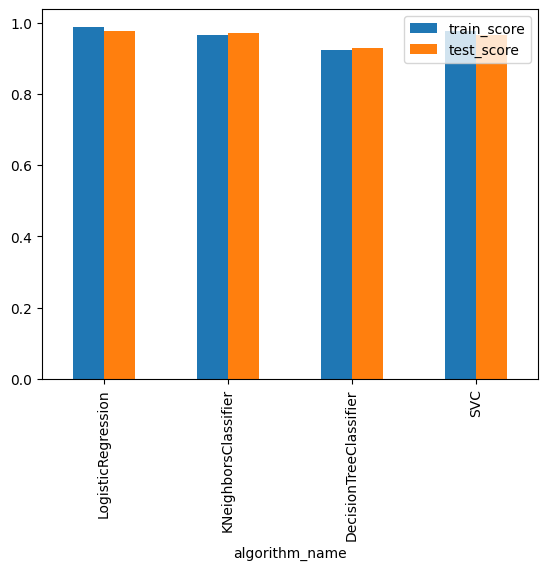

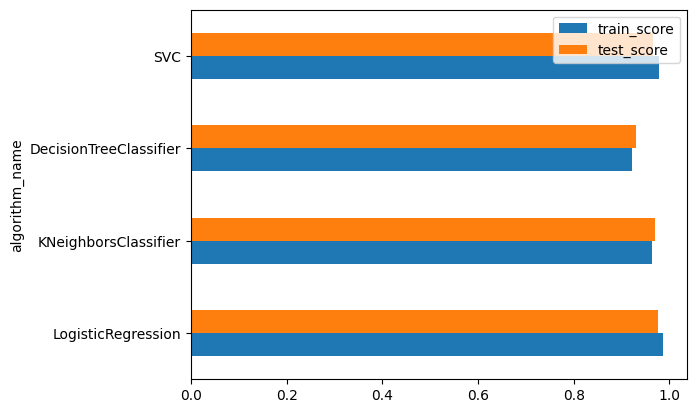

In [48]:
plt.figure(figsize=(10,5))
df.plot.bar(x='algorithm_name', y=['train_score', 'test_score'])
df.plot.barh(x='algorithm_name', y=['train_score', 'test_score']) # 가로
plt.show()
plt.close()

> 결과, SVC랑 LogisticRegression이 가장 정확도가 높은 상위 2건으로 확인되었다
>
> 이제 Voting에 이 두 알고리즘을 넣어서 해보면 됨

### 3-2) 알고리즘별 (시각화를 위한) 결과 데이터프레임 재구조화

In [52]:
df3 = melt(df, 
           id_vars=['algorithm_name'], 
           value_vars = ['train_score', 'test_score'],
           var_name='type',
           value_name='score')
df3

,algorithm_name,type,score
0,LogisticRegression,train_score,0.987405
1,KNeighborsClassifier,train_score,0.964747
2,DecisionTreeClassifier,train_score,0.922025
3,SVC,train_score,0.977373
4,LogisticRegression,test_score,0.976608
5,KNeighborsClassifier,test_score,0.970760
6,DecisionTreeClassifier,test_score,0.929825
7,SVC,test_score,0.964912


### 3-2) 알고리즘별 스코어 시각화

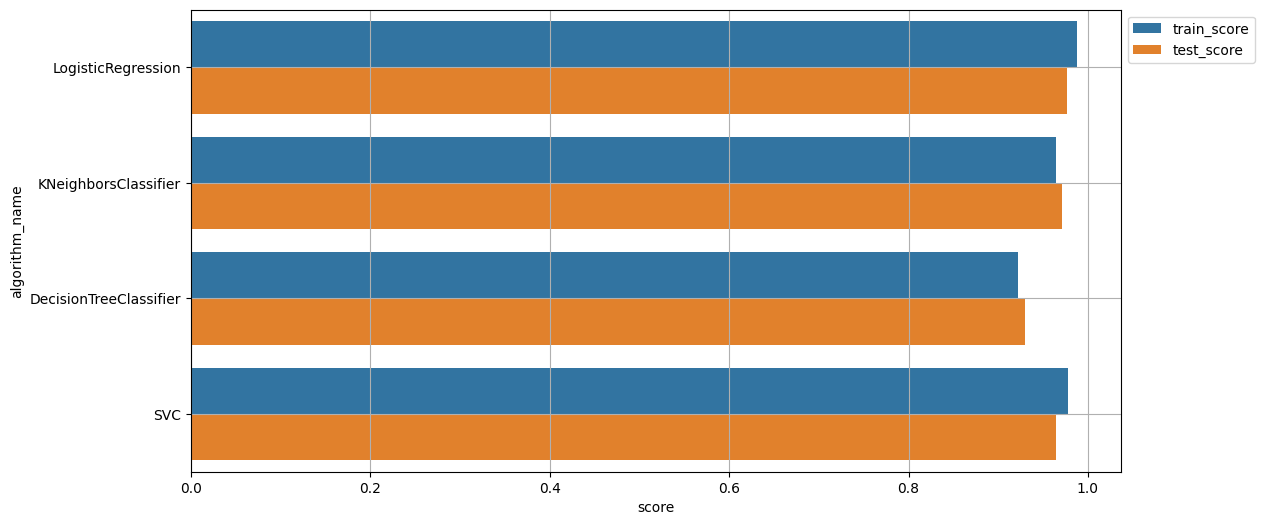

In [53]:
plt.figure(figsize = (12, 6))
sb.barplot(y='algorithm_name', x='score', hue='type', data=df3)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.show()
plt.close()

> 이 것을 근거로 특정 알고리즘을 보팅에 넣었다고 근거(이유)를 대면 됨!
>
> 후에 상위 2건인 LogisticRegression이랑 SVC를 갖고 Voting모델에 적용하여 수행하면 됨!